In [1]:
import numpy as np
from scipy.special import logsumexp
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime;now = datetime.now

from sklearn.mixture import BayesianGaussianMixture as BNP

In [2]:
class IBP_Graded:
    """
    Uncollapsed Gibbs sampler for infinite sparse factor analysis model
    """
    def __init__(self, alpha, sigma_n, sigma_a, sigma_y, K_trunc):
        self.alpha = alpha
        self.sigma_a = sigma_a
        self.sigma_n = sigma_n
        self.sigma_y = sigma_y

        self.K_trunc = K_trunc

        self.data = None

    def init_Z(self):
        K_init = 1
        # K_init = self.K_trunc

        Z = np.zeros((self.N, K_init))
        for i in range(self.N):
            Z[i] = np.random.choice(2)
        return Z

    def init_A(self, K):
        return np.stack([np.random.multivariate_normal(np.zeros(K),
            self.sigma_a * np.eye(K)) for _ in range(self.D)]).T

    def init_Y(self, K):
        return np.stack([np.random.multivariate_normal(np.zeros(K), 
            self.sigma_a * np.eye(K)) for _ in range(self.N)])

    def z_new_col_prior(self, k):
        # p(z_{i,k new} = 1 | Z_{-i, k})
        return sps.poisson(self.alpha / self.N).logpmf(k)

    def Z_prior(self, Z):
        # P(Z)
        lp = 0
        K = Z.shape[1]

        lp += K * np.log(self.alpha)

        sampled_dishes = 0

        counter = 0
        while sampled_dishes != K:
            counter += 1
            for k in range(K, sampled_dishes, -1):
                idx = np.where(Z[:, sampled_dishes:k] == np.ones(k))
                if idx is not None:
                    lp -= gammaln(k + 1)
                    sampled_dishes = k
                    break

            if counter > K:
                raise Exception("Z prior computation failed!")

        # asymptotic estimate of the nth harmonic number:
        # H_n = log(n) + gamma + 1/2n - 1/12n^2 + 1/120n^4 + O(1/n^6)
        gamma = 0.57721566490153286060651209008240243104215933593992
        Hn = gamma + np.log(self.N) + 0.5 / self.N - 1. / (12 * self.N ** 2) \
                + 1./(120 * self.N ** 4)

        lp -= self.alpha * Hn

        for k in range(K):
            z_sum = Z[:, k].sum()
            lp += gammaln(self.N - z_sum + 1) + gammaln(z_sum)
            lp -= gammaln(self.N + 1)

        return lp

    def A_prior(self, A):
        # P(A)
        lp = 0
        K = A.shape[0]

        lp -= self.D / 2 * np.log(2 * np.pi * self.sigma_a)
        lp -= 1 / (2 * self.sigma_a) * np.trace(np.dot(
            A.T,
            A
            ))

        return lp

    def Y_prior(self, Y):
        lp = 0
        K = Y.shape[1]

        lp = -self.K / 2 * np.log(2 * np.pi * self.sigma_y)
        lp -= 1 / (2 * self.sigma_y) * np.trace(np.dot(
            Y, Y.T
            ))

        return lp

    def log_lik_i(self, Z, A, Y, i):
        # p(X_i | Z, A)
        # if only Z_i changes, then only p(X_i | Z, A) changes
        lp = -self.likelihood_constant

        pred_mean = np.dot(Z[i] * Y[i], A)
        lp -= 1 / (2 * self.sigma_n) * np.dot(
                (self.data[i] - pred_mean).T,
                self.data[i] - pred_mean
                )

        return lp

    def log_lik(self, Z, A, Y):
        # p(X | Z, A)
        lp = - self.N * self.likelihood_constant

        pred_mean = np.dot(Z * Y, A)
        lp -= 1 / (2 * self.sigma_n) * np.trace(np.dot(
                (self.data - pred_mean).T,
                self.data - pred_mean
                ))

        return lp

    def log_joint(self, Z, Y, A):
        # P(Z, X, A)
        return self.Z_prior(Z) + self.A_prior(A) + self.log_lik(Z, A, Y)

    def sample_A(self, Z, Y):
        K = Z.shape[1]
        
        factors = Z * Y
        inv_mat = np.linalg.inv(
                np.dot(factors.T, factors) + (self.sigma_n / self.sigma_a) * np.eye(K)
                )
        mu = np.dot(inv_mat,
                np.dot(factors.T, self.data))
        # cov = self.sigma_n * inv_mat

        # return np.stack([np.random.multivariate_normal(mu_i, cov) for
        #     mu_i in mu.T]).T
        return mu

    def sample_Y_i(self, Z, A, Y, i):
        Y_new = Y.copy()
        K = Z.shape[1]

        loadings = Z[i, :, None] * A
        inv_mat = np.linalg.inv(
                np.dot(loadings, loadings.T) + \
                        (self.sigma_n / self.sigma_y) * np.eye(K)
                        )
        mu = np.dot(inv_mat, np.dot(
            loadings, self.data[i].T))
        # cov = self.sigma_n * inv_mat
        # Y_new[i] = np.random.multivariate_normal(mu, cov)
        Y_new[i] = mu

        return Y_new

    def sample_new_columns(self, Z, A, Y, i, lp_no_col):
        # propose adding new columns
        K = Z.shape[0]
        lp_new_col = np.zeros(self.K_trunc)
        lp_new_col[0] = lp_no_col + self.z_new_col_prior(0)

        new_col = np.zeros((self.N, self.K_trunc))
        new_col[i] = 1

        new_features = self.init_A(self.K_trunc)
        new_factors = self.init_Y(self.K_trunc)

        for k in range(1, self.K_trunc):
            Z_tmp = np.concatenate((Z, new_col[:, :k]), axis=1)
            A_tmp = np.concatenate((A, new_features[:k, :]), axis=0)
            Y_tmp = np.concatenate((Y, new_factors[:, :k]), axis=1)

            lp_new_col[k] = self.log_lik(Z_tmp, A_tmp, Y_tmp) + self.z_new_col_prior(k)

        lp_new_col = lp_new_col - logsumexp(lp_new_col)
        k_new = np.random.choice(self.K_trunc, p = np.exp(lp_new_col))

        if k_new == 0:
            return Z, A, Y
        else:
            return (Z_tmp[:K + k_new], A_tmp[:K + k_new, :], 
                    Y_tmp[:, :K + k_new])

    def sample_Z_ik(self, Z, A, Y, i, k, lp):
        z_sum = Z[:, k].sum() - Z[i, k]
        lp_no_i = lp - self.log_lik_i(Z, A, Y, i)

        Z[i, k] = 0
        lprior_0 = np.log(self.N - z_sum) - np.log(self.N)
        lp_0 = lp_no_i + self.log_lik_i(Z, A, Y, i)

        Z[i, k] = 1
        lprior_1 = np.log(z_sum) - np.log(self.N)
        lp_1 = lp_no_i + self.log_lik_i(Z, A, Y, i)

        accept_prob = lp_1 + lprior_1 - \
                np.logaddexp(lp_1 + lprior_1, lp_0 + lprior_0) 

        if np.log(np.random.uniform()) <= accept_prob:
            return 1, lp_1
        else:
            return 0, lp_0

    def sample(self, Z_prev, A_prev, Y_prev):
        Z = Z_prev.copy()
        A = A_prev.copy()
        Y = Y_prev.copy()
        lp = 0

        for i in range(Z.shape[0]):
            lp = self.log_lik(Z, A, Y)
            for k in range(Z.shape[1]):
                if (Z[:, k].sum() - Z[i, k]) == 0:
                    lp -= self.log_lik_i(Z, A, Y, i)
                    Z[i, k] = 0
                    lp += self.log_lik_i(Z, A, Y, i)
                else:
                    Z[i, k], lp = self.sample_Z_ik(Z, A, Y, i, k, lp)

            nonempty = np.where(Z.sum(axis=0) != 0)[0]

            Z = Z[:, nonempty]
            A = A[nonempty, :]
            Y = Y[:, nonempty]

            # sample new columns
            Z, A, Y = self.sample_new_columns(Z, A, Y, i, lp)

            Y = self.sample_Y_i(Z, A, Y, i)
            A = self.sample_A(Z, Y)

        return Z, A, Y

    def observe(self, data):
        self.data = data
        self.N, self.D = data.shape

        self.likelihood_constant = self.D / 2 * \
                np.log(2 * np.pi * self.sigma_n)

    def infer(self, data, burn=10, n_iter=25):
        print('burnin');t0 = now()
        if self.data is None:
            self.observe(data)

        Z = self.init_Z()
        A = self.init_A(Z.shape[1])
        Y = self.init_Y(Z.shape[1])

        for i in range(burn):
            if i % 5 == 0:
                self.full_rank_update = True
            #print("iteration ", i)
            Z, A, Y = self.sample(Z, A, Y)
            #print(self.log_lik(Z, A, Y))
            # print(Z.shape[1])
            # print(np.sum((np.dot(Z * Y, A) - self.data) ** 2))

        #breakpoint()
        #print("=======================sampling==================")

        map_estimate = (Z, A, Y)
        lp = -np.inf
        for i in range(n_iter):
            #print(i)
            Z, A, Y = self.sample(Z, A, Y)
            lp_new = self.log_lik(Z, A, Y)

            if lp_new > lp:
                map_estimate = (Z, A, Y)
                lp = lp_new
        print('done')
        print(now()-t0)
        return map_estimate, lp

In [3]:
N = 50
D = 2

Z = np.zeros((N, D))
Z[:N//2, 0] = np.arange(N // 2) / (N // 2)
Z[N//2:, 1] = np.arange(N // 2) / (N // 2)

A = np.random.normal(np.zeros((2, 2)), 1)
data_factor = np.dot(Z, A) + np.random.normal(0, .05, size=(N, D))

In [4]:
data_factor.shape

(50, 2)

Text(0.5, 1.0, 'data_factor')

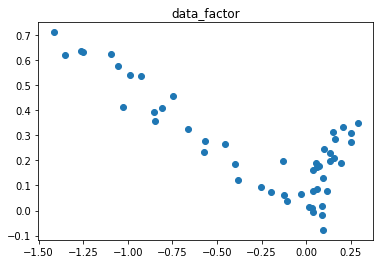

In [5]:
plt.scatter(data_factor[:,0],data_factor[:,1]);
plt.title('data_factor')

In [6]:
from sklearn.datasets import make_blobs
data_cluster, data_cluster_ID = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0,cluster_std=0.1)

Text(0.5, 1.0, 'data_cluster')

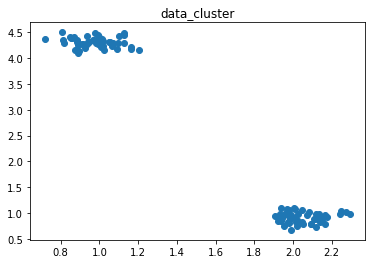

In [7]:
plt.scatter(data_cluster[:,0],data_cluster[:,1])
plt.title('data_cluster')

In [8]:
# Fit DFMF
DFMF = IBP_Graded(1, 1, 1, 1, 5)
map_estimateF, lpF = DFMF.infer(data_factor,burn=20, n_iter=100)

burnin
done
0:01:40.281794


In [9]:
[F.shape for F in map_estimateF]

[(50, 13), (13, 2), (50, 13)]

In [10]:
# Fit DFMF
DFMC = BNP(max_iter=1000,n_components=5,covariance_type=['full','tied','diag' ,'spherical'][0],init_params='kmeans',tol=1e-5,weight_concentration_prior_type='dirichlet_process',weight_concentration_prior=1,mean_precision_prior=.001,degrees_of_freedom_prior=None)
DFMC.fit(data_factor)
DFMC_pred = DFMC.sample(100)
DFMC_pred = DFMC_pred[0]

In [11]:
DCMC = BNP(max_iter=1000,n_components=5,covariance_type=['full','tied','diag' ,'spherical'][0],init_params='kmeans',tol=1e-5,weight_concentration_prior_type='dirichlet_process',weight_concentration_prior=1,mean_precision_prior=.001,degrees_of_freedom_prior=None)
DCMC.fit(data_cluster)
DCMC_pred = DCMC.sample(100)
DCMC_pred = DCMC_pred[0]

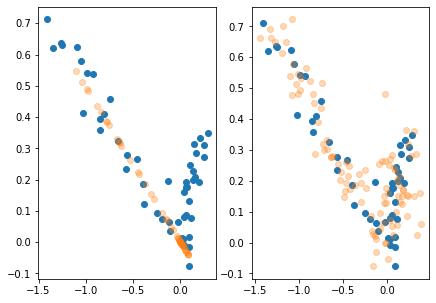

In [12]:
(Z_mapF, A_mapF, Y_mapF) = map_estimateF
DFMF_pred = np.dot(Z_mapF * Y_mapF, A_mapF)

plt.figure(figsize=(7,5))
plt.subplot(1,2,1)
plt.scatter(data_factor[:,0],data_factor[:,1])
plt.scatter(DFMF_pred[:,0],DFMF_pred[:,1],alpha=.3)

plt.subplot(1,2,2)
plt.scatter(data_factor[:,0],data_factor[:,1])
plt.scatter(DFMC_pred[:,0],DFMC_pred[:,1],alpha=.3)

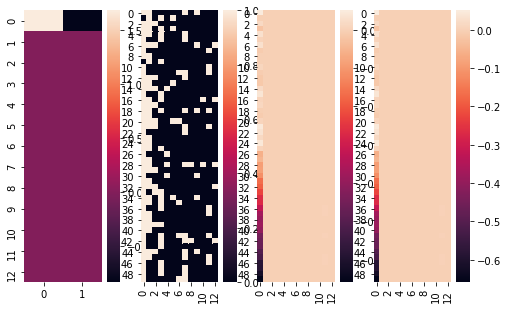

In [13]:
plt.figure(figsize=(8,5))
plt.subplot(1,4,1);sns.heatmap(A_mapF)
plt.subplot(1,4,2);sns.heatmap(Z_mapF)
plt.subplot(1,4,3);sns.heatmap(Y_mapF)
plt.subplot(1,4,4);sns.heatmap(Z_mapF*Y_mapF)

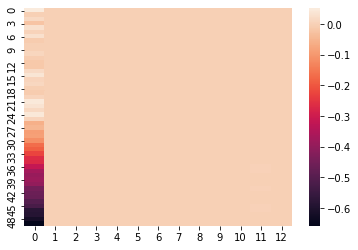

In [14]:
sns.heatmap(Z_mapF*Y_mapF)

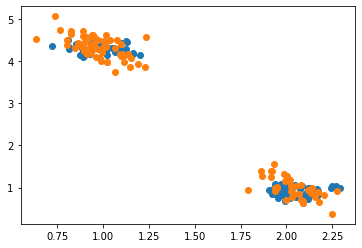

In [15]:
plt.scatter(data_cluster[:,0],data_cluster[:,1])
plt.scatter(DCMC_pred[:,0],DCMC_pred[:,1])

<BarContainer object of 5 artists>

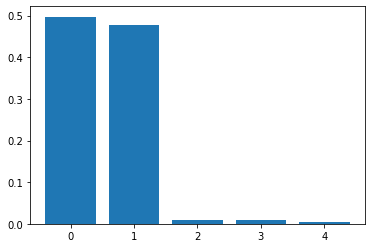

In [16]:
y = DCMC.weights_
y = np.sort(y)[::-1]
plt.bar(np.arange(len(y)),y)

Text(0.5, 0, 'cluster')

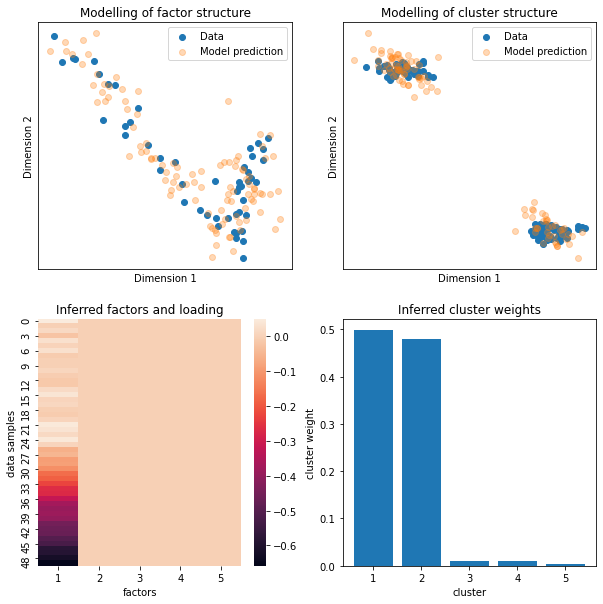

In [17]:
plt.figure(figsize=(10,10))
xs = np.arange(5)

plt.subplot(2,2,1)
plt.scatter(data_factor[:,0],data_factor[:,1])
plt.scatter(DFMC_pred[:,0],DFMC_pred[:,1],alpha=.3)

plt.xticks([]);plt.yticks([])
plt.xlabel('Dimension 1');plt.ylabel('Dimension 2')

plt.title('Modelling of factor structure')
plt.legend(['Data','Model prediction'])

plt.subplot(2,2,2)
plt.scatter(data_cluster[:,0],data_cluster[:,1])
plt.scatter(DCMC_pred[:,0],DCMC_pred[:,1],alpha=.3)

plt.title('Modelling of cluster structure')
plt.legend(['Data','Model prediction'])

plt.xticks([]);plt.yticks([])
plt.xlabel('Dimension 1');plt.ylabel('Dimension 2')

plt.subplot(2,2,3)
L = Z_mapF*Y_mapF
sns.heatmap(L[:,0:5])
plt.xticks(np.arange(.5,5.5),labels=np.arange(1,6))
plt.title('Inferred factors and loading')
plt.ylabel('data samples');plt.xlabel('factors')

plt.subplot(2,2,4)
y = DCMC.weights_
y = np.sort(y)[::-1]
plt.bar(np.arange(len(y)),y)
plt.xticks(xs,labels=xs+1)
plt.title('Inferred cluster weights')

plt.ylabel('cluster weight');plt.xlabel('cluster')

In [18]:
sns.heatmap?